In [225]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import sys
import math
import os
import numpy as np
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')

# local code
sys.path.insert(1, "./code/")
from Utils import Utils # student's library
from Eval import Eval # student's library
from Extract import Extract # student's library


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/peterkong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [141]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [142]:
# sanity checks
#train_df.id.nunique()
# 19579

#train_df.author.unique()
# array(['EAP', 'HPL', 'MWS'], dtype=object)

In [143]:
Utils.check_for_nulls(train_df)

{'author': 0, 'id': 0, 'text': 0}

In [144]:
short_df = train_df[:20]
short_df.head(1)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP


In [145]:
# splitting data

# regular data
#     train: 19580 * .9 rows
#     test:  8393 rows
#     val:   19580 * .1 rows


if os.path.isfile('data/traindata.pickle'):
    traindata = pd.read_pickle('data/traindata.pickle')
    valdata   = pd.read_pickle('data/valdata.pickle')
    testdata  = pd.read_pickle('data/testdata.pickle')
else: 
    VAL_IDX  = math.ceil(len(train_df) * .8)
    TEST_IDX = math.ceil(len(train_df) * .9)

    traindata = train_df[:VAL_IDX]
    valdata   = train_df[VAL_IDX:TEST_IDX]
    testdata  = train_df[TEST_IDX:]

    print(VAL_IDX, TEST_IDX)

    traindata.to_pickle('data/traindata.pickle')
    valdata.to_pickle('data/valdata.pickle')
    testdata.to_pickle('data/testdata.pickle')

In [176]:
print("traindata: {}, valdata: {}, testdata: {}".format(len(traindata), len(valdata), len(testdata)))

traindata: 15664, valdata: 1958, testdata: 1957


In [177]:
# grammatical feature engineering 
# we want to include stopwords here

if os.path.isfile('data/train_gram_feats.pickle'):
    print("reading gram feats from pickle")
    train_gram_feats_df = pd.read_pickle('data/train_gram_feats_df.pickle')
    val_gram_feats_df   = pd.read_pickle('data/val_gram_feats_df.pickle')
    test_gram_feats_df  = pd.read_pickle('data/test_gram_feats_df.pickle')
else:
    seq_no = None
    train_gram_feats_df = Extract.gram_feats(traindata.text, None, seq_no)

    # need to remember so that val/test process
    # does not add additional columns
    GRAM_FEAT_LIST = list(train_gram_feats_df.columns)

    val_gram_feats_df = Extract.gram_feats(valdata.text, GRAM_FEAT_LIST, seq_no)
    test_gram_feats_df = Extract.gram_feats(testdata.text, GRAM_FEAT_LIST, seq_no)

    # there are 21 columns excluding sequence columns 
    # 7ary sequence columns can generate up to 2187
    
    train_gram_feats_df.to_pickle('data/train_gram_feats_df.pickle')
    val_gram_feats_df.to_pickle('data/val_gram_feats_df.pickle')
    test_gram_feats_df.to_pickle('data/test_gram_feats_df.pickle')    


In [178]:
# removes a singleton feature
for df in train_gram_feats_df, val_gram_feats_df, test_gram_feats_df:
    if 'SYM_count' in list(df.columns):
        df.drop('SYM_count', axis=1, inplace=True)
        
print(train_gram_feats_df.shape)
print(val_gram_feats_df.shape)
print(test_gram_feats_df.shape)

#set(GRAM_FEAT_LIST) - set(list(val_gram_feats_df.columns))

(15664, 23)
(1958, 23)
(1957, 23)


In [179]:
train_gram_feats_df.shape

(15664, 23)

In [180]:
# textual feature engineering
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=STOPWORDS, max_features=100)

train_text_feats = vectorizer.fit_transform(traindata.text)
Y_train = traindata.author 

val_text_feats = vectorizer.transform(valdata.text) 
Y_val = list(valdata.author)

test_text_feats = vectorizer.transform(testdata.text) 
Y_test = list(testdata.author)



In [181]:
#convert text feats to pandas
print(train_text_feats.shape)
print(val_text_feats.shape)
print(test_text_feats.shape)

cols = ["text_" + str(x) for x in range(train_text_feats.shape[1])]

train_text_feats_df = pd.DataFrame(train_text_feats.todense(), index=None, columns=cols)
val_text_feats_df = pd.DataFrame(val_text_feats.todense(), index=None, columns=cols)
test_text_feats_df = pd.DataFrame(test_text_feats.todense(), index=None, columns=cols)

print(train_text_feats_df.shape)
print(val_text_feats_df.shape)
print(test_text_feats_df.shape)


(15664, 100)
(1958, 100)
(1957, 100)
(15664, 100)
(1958, 100)
(1957, 100)


In [182]:
# concatenating features

X_train = train_gram_feats_df.fillna(0)#.join(train_text_feats_df).fillna(0)
X_val = val_gram_feats_df.fillna(0)#.join(val_text_feats_df).fillna(0)
X_test = test_gram_feats_df.fillna(0)#.join(test_text_feats_df).fillna(0)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(15664, 23)
(1958, 23)
(1957, 23)


In [183]:
#X_train.sum(axis=0).sort_values

In [184]:
#sanity checking
assert(list(X_train.columns) == list(X_val.columns))
assert(list(X_train.columns) == list(X_test.columns))

In [185]:
import numpy as np
import gensim

# http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

# this glove code is wrong type for later work
# with open("data/glove.42B.300d.txt", "rb") as lines:
#     w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
#            for line in lines}


# let X be a list of tokenized texts (i.e. list of lists of tokens)
# sentences param is token lists

# model = gensim.models.Word2Vec(short_sents, size=100)
# w2v = dict(zip(model.wv.index2word, model.wv.vectors))
# type(w2v)

In [186]:
#list(w2v.keys())[9990:9999]
# [b'iconic',
#  b'erp',
#  b'crest',
#  b'radius',
#  b'spiral',
#  b'nyse',
#  b'lotion',
#  b'oriental',
#  b'admire']

In [187]:
# a_key = list(w2v.keys())[9999]
# a_key.decode("utf-8")

In [188]:
#type(w2v[str.encode('owl')])

In [189]:
#https://radimrehurek.com/gensim/models/doc2vec.html
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#TaggedDocument does not filter or stem

# documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(short_sents)]
# model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# vector = model.infer_vector(["system", "response"])
# vector

In [190]:
# order of ops:
# just grammar features
# just tfidf vectorizer
# both

# kmeans

In [191]:
# linear svc
from sklearn.svm import LinearSVC

lin_clf = LinearSVC()
lin_clf.fit(X_train, Y_train) 
preds = lin_clf.predict(X_val)
preds

array(['EAP', 'EAP', 'EAP', ..., 'EAP', 'EAP', 'EAP'], dtype=object)

In [192]:
# evaluation

accuracy = Eval.get_accuracy(preds, Y_val)
print("Accuracy: ", accuracy)

Accuracy:  0.4964249233912155


In [220]:
import importlib
import Extract
import Utils
importlib.reload(Extract)
importlib.reload(Utils)
from Utils import Utils


In [194]:
import time
timenow = time.asctime( time.localtime(time.time()) )
print("Finished at: ", timenow)

Finished at:  Mon Dec  3 23:54:55 2018


array(['EAP', 'HPL', 'MWS'], dtype=object)

In [223]:
# exploration

mws_df = train_df[train_df.author == 'MWS']
mws_lexicon = Utils.build_lexicon(mws_df.text, STOPWORDS)

hpl_df = train_df[train_df.author == 'HPL']
hpl_lexicon = Utils.build_lexicon(hpl_df.text, STOPWORDS)

eap_df = train_df[train_df.author == 'EAP']
eap_lexicon = Utils.build_lexicon(eap_df.text, STOPWORDS)

# sanity check
assert(len(train_df) == len(mws_df) + len(hpl_df) + len(eap_df))

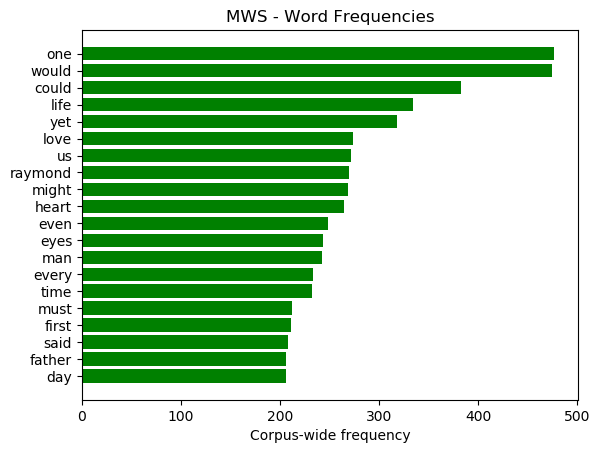

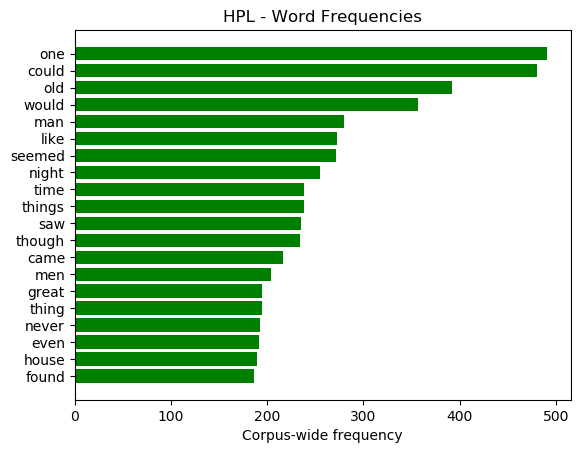

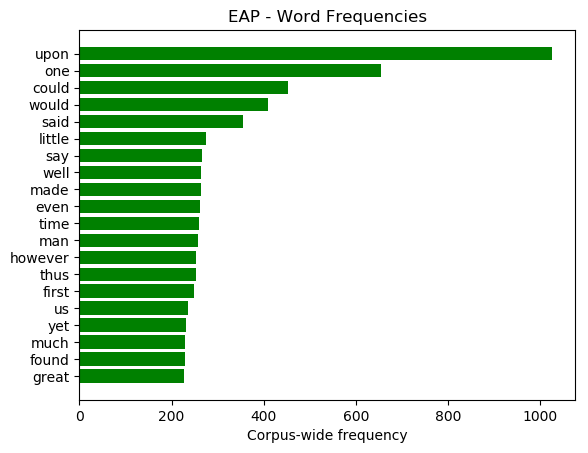

In [245]:
# data viz

def plot_word_freq(lexicon, name, quantity=20):
    plt.rcdefaults()
    fig, ax = plt.subplots()

    elems = [x[0] for x in lexicon[:quantity]]
    y_pos = np.arange(quantity)
    vals = [x[1] for x in lexicon[:quantity]]

    ax.barh(y_pos, vals, align='center',
            color='green', ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(elems)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Corpus-wide frequency')
    ax.set_title(name + ' - Word Frequencies')

    plt.show()
 
authors = {'MWS': mws_lexicon, 'HPL': hpl_lexicon, 'EAP': eap_lexicon}

for key in authors:
    plot_word_freq(authors[key], key)


In [239]:
mws_lexicon[:20]

[('one', 477),
 ('would', 475),
 ('could', 383),
 ('life', 334),
 ('yet', 318),
 ('love', 274),
 ('us', 272),
 ('raymond', 270),
 ('might', 269),
 ('heart', 265),
 ('even', 248),
 ('eyes', 243),
 ('man', 242),
 ('every', 233),
 ('time', 232),
 ('must', 212),
 ('first', 211),
 ('said', 208),
 ('father', 206),
 ('day', 206)]